# CNN w/ Keras on TF
## We compare a single model architecture under the following modifications:
## - vanilla
## - vanilla + learning_rate_reduction
## - vanilla + learning_rate_reduction + data augmentation

# Set up

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy import stats
import random
import cPickle as pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.utils import to_categorical # For keras > 2.0
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

#for model3
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation

# Data Preprocessing

In [67]:
train = pd.read_csv("~/.kaggle/competitions/digit-recognizer/train.csv")
test = pd.read_csv("~/.kaggle/competitions/digit-recognizer/test.csv")

In [68]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

del train 

*"Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive."*

In [69]:
print(Y_train.shape)
print(X_train.shape)

(42000,)
(42000, 784)


In [70]:
print(X_train.min().min())
print(X_train.max().max())
# print(X_train.shape)

0
255


We reshape the data from pandas.Dataframes of 1D vectors of 784 values to 3D (28x28x1) matrices. The 3rd dim is req'd by Keras, corresponding to channels. Since MNIST images are gray scaled, so it uses only one channel (as opposed to RGB images having 3 channels). 

In [71]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

We encode Y_train (training labels) to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

In [72]:
print(Y_train.shape)
print(Y_train.describe())
print(np.array(Y_train.head()))

(42000,)
count    42000.000000
mean         4.456643
std          2.887730
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: label, dtype: float64
[1 0 1 4 0]


In [73]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [74]:
print(Y_train.shape)
print(pd.DataFrame(Y_train).describe())

(42000, 10)
                  0             1             2             3             4  \
count  42000.000000  42000.000000  42000.000000  42000.000000  42000.000000   
mean       0.098381      0.111524      0.099452      0.103595      0.096952   
std        0.297833      0.314783      0.299272      0.304738      0.295896   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                  5             6             7             8             9  
count  42000.000000  42000.000000  42000.000000  42000.000000  42000.000000  
mean       0.090357      0.098500      0.104786      0.096738      0.099714  
std        0.286696      0.297993      0.3

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

We split training and valdiation set 

In [75]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

We can get a better sense for one of these examples by visualising the image and looking at the label.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


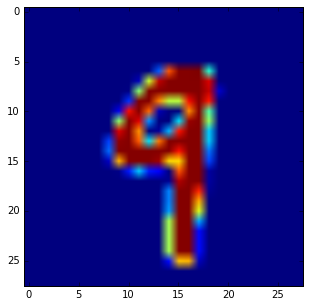

In [76]:
i = random.randint(0, 9) 
print(Y_train[i])
plt.imshow(X_train[i][:,:,0])

# Define CNN Model 1
In other notebooks, we compare 4 different model architectures  which all share the following hyper parameters

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 30
batch_size = 86

img_rows, img_cols = 28, 28

nb_filters_1 = 32 
nb_filters_2 = 64 
nb_filters_3 = 128 

nb_conv = 3 # kernel_size dim
nb_classes = Y_train.shape[1]


## CNN Model #1:
Based on [yassineghouzam](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6). 

**Layer 1, 2, 5, 6:** convolutional (Conv2D) layer with nb_filters_1 (32) filters for 1&2 and nb_filters_2 (64) filters for 5&6. Each filter transforms a part of the image defined by the kernel size nb_conv (3) using the kernel filter. 'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

**Layer 3, 7:** Each sequence of two convolution (Conv2D) layers os followed by the pooling (MaxPool2D) layer, which acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value (reduce computational cost, reduce overfitting). 

*Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.*

**Layer 4, 8, 11:** Each pooling layer is followed by dropout (Dropout), is a regularization method in which a random proportion of the nodes in a layer are randomly ignored by setting their wieghts to zero. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

**Layer 9:** The Flatten layer converts the final feature maps into a one single 1D vector. It combines all the found local features of the previous convolutional layers and makes it possible to use of fully connected layers after the convolutional/maxpool layers. 

**Layer 10, 12:** Finally, two fully-connected (Dense) layers which are just artificial an neural networks (ANN) classifiers. In the last layer(Dense(10,activation="softmax")), the net outputs distribution of probability of each class.

**Without data augmentation: After 02 epochs:** val_acc: 0.9821<br>
**Without data augmentation: After 30 epochs:** val_acc: 0.9919



In [18]:
model1 = Sequential()
model1.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (28,28,1)))
model1.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))
model1.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(nb_classes, activation = "softmax"))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [19]:
# Define the optimizer & Compile the model
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model1.compile(optimizer = optimizer , \
              loss = "categorical_crossentropy", \
              metrics=["accuracy"])

# First, 
## we run the model with no learning rate reduction and no data augmentation

In [24]:
history1_A = pickle.load( open( 'model1_history_30epochs_noLRred.p', 'rb'))

# Second, 
## we run the model with learning rate reduction but no data augmentation

In [30]:
history1_B = pickle.load( open( 'model1_history_30epochs.p', 'rb'))

# Third, 
## we run the model with learning rate reduction and with data augmentation

Based on [yassineghouzam](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6):

- Randomly rotate some training images by 10 degrees
- Randomly Zoom by 10% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height
- No vertical_flip or horizontal_flip 


Note the replacement of `model1.fit` with `model1.fit_generator` for fitting the model on batches with real-time data augmentation

In [26]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [27]:
history1_C = pickle.load( open( 'model1_history_30epochs_wDAug.p', 'rb'))

# Compare 
## Training & Validation accuracy across epochs & model variations

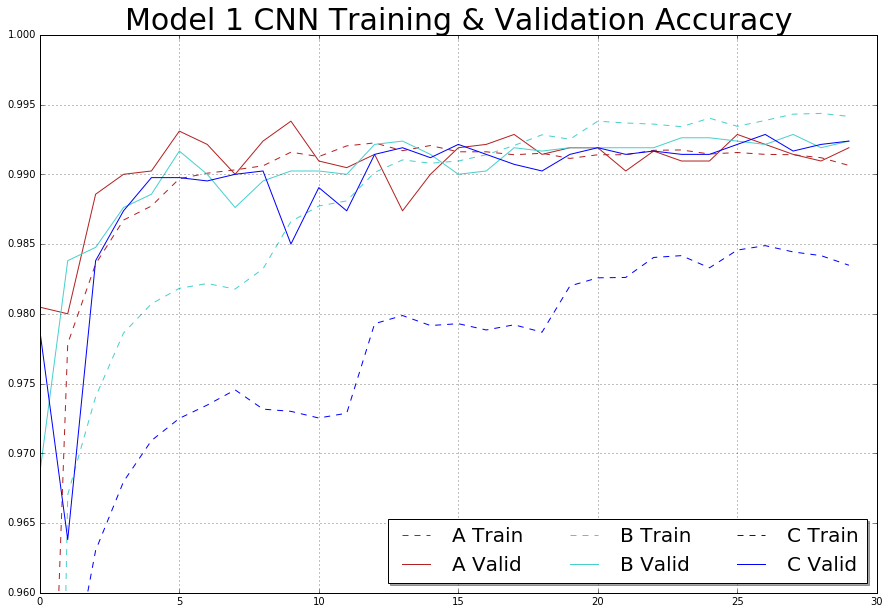

In [36]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.ylim(ymin=.96)

plt.plot(history1_A['acc'], color='firebrick', linestyle='--', label="A Train")
plt.plot(history1_A['val_acc'], color='firebrick',label="A Valid")

plt.plot(history1_B['acc'], color='mediumturquoise', linestyle='--', label="B Train")
plt.plot(history1_B['val_acc'], color='mediumturquoise',label="B Valid")

plt.plot(history1_C['acc'], color='b', linestyle='--', label="C Train")
plt.plot(history1_C['val_acc'], color='b',label="C Valid")

plt.title("Model 1 CNN Training & Validation Accuracy", fontsize=30)
plt.legend(loc=4, prop={'size': 20}, shadow=True, ncol=3)
plt.grid()

# Analysis Discussion

Our initial, vanilla model (no learning rate) leads to training and validation score that hover aorund the same values -- with training scores often exceeding those of validation scores (with this occuring 40% of the time!), indicating that the model is overfitting.

We could look to increase the number of MaxPool2D and Dropout layers to reduce the amount of overfitting. We could also 

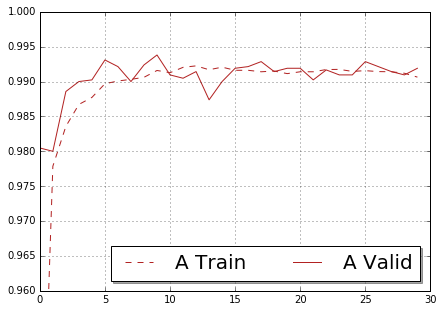

In [38]:
plt.rcParams['figure.figsize'] = [7, 5]
plt.ylim(ymin=.96)

plt.plot(history1_A['acc'], color='firebrick', linestyle='--', label="A Train")
plt.plot(history1_A['val_acc'], color='firebrick',label="A Valid")

plt.legend(loc=4, prop={'size': 20}, shadow=True, ncol=3)
plt.grid()

In [46]:
acc_list = zip(history1_A['acc'], history1_A['val_acc'])
sum([x[0] > x[1] for x in acc_list])/float(len(acc_list))

0.4

One method to prevent overfitting is augmenting the data used to train the model (essentially manufacturing additional training samples to reproduce variations we might see in "real life data" of handwritten digits that are nit alreayd represented by the data). For each augmentation, we change the array representation but keep the label the same.



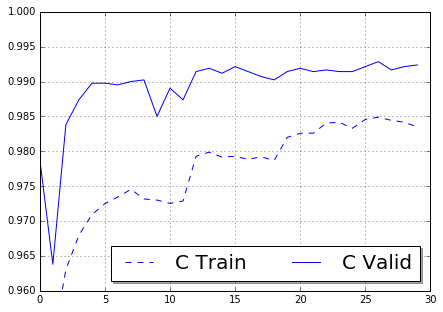

In [48]:
plt.rcParams['figure.figsize'] = [7, 5]
plt.ylim(ymin=.96)

plt.plot(history1_C['acc'], color='b', linestyle='--', label="C Train")
plt.plot(history1_C['val_acc'], color='b',label="C Valid")

plt.legend(loc=4, prop={'size': 20}, shadow=True, ncol=3)
plt.grid()

Having applied data augmentationm, we see that the validation scores far exceed the training scores 100% of the time, over all epochs.

We also see that  see that, as a esult of learning rate annealing (in both Model 1_B and Model 1_C), our validation scores are less volatile at higher epochs (when learning rate has been reduced). And, ultimately our final vlaiation score is higher. 

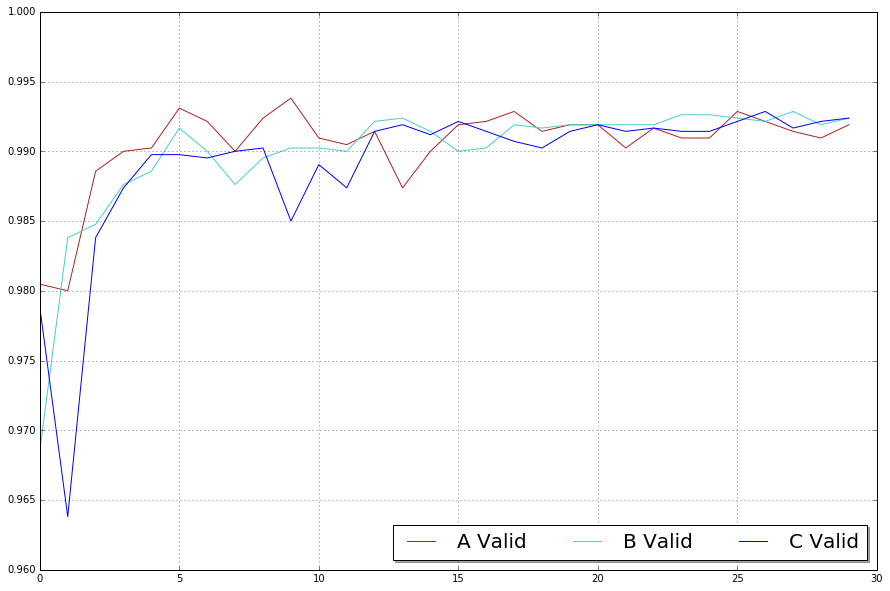

In [102]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.ylim(ymin=.96)

plt.plot(history1_A['val_acc'], color='firebrick',label="A Valid")
plt.plot(history1_B['val_acc'], color='mediumturquoise',label="B Valid")
plt.plot(history1_C['val_acc'], color='b',label="C Valid")

plt.legend(loc=4, prop={'size': 20}, shadow=True, ncol=3)
plt.grid()

However, across all epochs, Model 1_A still receieved a higher validation score overall.

In [100]:
print ("Final Validation Score of Model 1_A: %f" % (history1_A['val_acc'][-1]))
print ("Final Validation Score of Model 1_B: %f" % (history1_B['val_acc'][-1]))
print ("Final Validation Score of Model 1_C: %f" % (history1_C['val_acc'][-1]))
print
print ("Best Validation Score of Model 1_A: %f" % max(history1_A['val_acc']))
print ("Best Validation Score of Model 1_B: %f" % max(history1_B['val_acc']))
print ("Best Validation Score of Model 1_C: %f" % max(history1_C['val_acc']))


Final Validation Score of Model 1_A: 0.991905
Final Validation Score of Model 1_B: 0.992381
Final Validation Score of Model 1_C: 0.992381

Best Validation Score of Model 1_A: 0.993810
Best Validation Score of Model 1_B: 0.992857
Best Validation Score of Model 1_C: 0.992857

